# Final Project - Steve's Notebook

MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Spring 2019

Final Project: Click Through Rate Prediction

## Algorithm Explanation

Create your own toy example that matches the dataset provided and use this toy example to explain the math behind the algorithm that you will perform.

For this project, we have built a Factorization Machine algorithm from the ground up, and applied it to a small sample dataset.  For the full dataset, we have implemented a Logistic Regression algorithm utilizing Spark ML methods.

The Factorization Machine algorithm that we built was based on two papers by Steffen Rendle:  
1. Factorization Machines (Data Mining (ICDM), 2010 IEEE 10th International Conference on. (2010) 995–1000,  
https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf), and  
2. Factorization Machines with libFM (ACM Transactions on Intelligent Systems and Technology, Vol. 3, No. 3, Article 57, Publication date: May 2012., https://www.csie.ntu.edu.tw/~b97053/paper/Factorization%20Machines%20with%20libFM.pdf).  
The second Rendle paper was particularly helpful for algorithm explanation, and we used "Algorithm 1" in that paper for intuition to guide implementation of our home-grown FM algorithm.

Equation 1 shows the basic relationship between the predicted target variable $\hat{y}$ and the independent variables in the second-order Factorization Machine model. 


\begin{equation} \tag{1}
\hat{y}(\boldsymbol{x}) = w_0 + \sum_{j=1}^{p}w_j x_j + \sum_{j=1}^{p} \sum_{j'=j+1}^{p}x_j x_j' \sum_{f=1}^{k}v_{j,f} v_{j',f}  
\end{equation}

where $\boldsymbol{x} \in \mathbb{R} ^{p}$ is a feature vector with $p$ real-valued variables.  Here $k$ is the dimensionality of the factorization, also known as the number of latent factors, and the model parameters are 

\begin{equation} \tag{2}
w_0 \in \mathbb{R}, \space\space\space  \boldsymbol{w} \in \mathbb{R}^p,  \space\space\space  V \in \mathbb{R}^{p \times k} 
\end{equation}



The first part of the FM model in eq. 1 is the same as a standard regression model, in that we have the bias $w_0$ and the linear terms $w_j x_j$.  The second part of the FM equation captures the second-order (pair-wise) interactions between the independent variables, $x_j x_{j'}$.  An important distinction here is that, in contrast to standard polynomial regression, the coefficients for the interaction terms are not independent parameters $w_{j,j'}$, but rather a factorized parameterization of $w_{j,j'} \approx \sum_{f=1}^{k}v_{j,f} v_{j',f}$, which is shown in the last summation summation in eq. 1.  This reflects the assumption that $w_{j,j'}$ can be approximated by low-rank matrices, where $k \ll p$.  This allows FMs to estimate the interaction parameters reliabily, even in the presence of highly sparse data where standard models fail.

Our approach in the home-grown algorithm is to include all these terms in the model and to implement using batch gradient descent.  In contrast, standard Alternating Least Squares (ALS) algorithm uses only the interaction terms, without the linear terms.  Also, standard regression models often omit interaction terms.  The more ideal approach is to retain the linear terms and the interaction terms, as we have implemented for a small sample from our dataset.  Our current FM implementation has $O(n^2k)$ time complexity; a future enhancement could be undertaken to achieve a $O(nk)$ time complexity, as described in Rendle(2010).   

Our training task is to find the optimal model parameters $\Theta$ such that we minimize the sum of the losses over the observed data $S$, given the appropriate loss function $L$.  This takes the general form:

\begin{equation} \tag{3}
OptReg(S,\lambda) = argmin_{\theta} \bigg( \sum_{(\boldsymbol{x},y)\in S}L(\hat{y}(\boldsymbol{x}|\Theta,y) + Reg_{\lambda_{\theta}} \bigg) 
\end{equation}

where $Reg$ contains the regularization penalty.  

In the home-grown algorithm, we use $L_2$ regularization (where $\lambda_{\theta}$ is the regularization strength):

\begin{equation} \tag{4}
Reg_{L_2} = \sum_{\theta \in \Theta} \lambda_{\theta} \theta^2   
\end{equation}


With this binary classification problem, with $y \in$ {0,1}, we leverage Andrew Ng's treatment (https://www.youtube.com/watch?v=TTdcc21Ko9A&feature=youtu.be) of the log loss function, $L$:

\begin{equation} \tag{5}
L(\theta) = - \frac{1}{m} \sum_{i=1}^{m} \bigg( y^{(i)} log \space h_{\theta}(x^{(i)}) + (1-y^{(i)}) log \big( 1-h_{\theta}(x^{(i)}) \big)  \bigg), 
\end{equation}

(which is algebrically simplified in the algorithm for $y^{(i)}=0$ and $y^{(i)}=1$) where $m$ is the number of training examples, and $h_{\theta}(x)$ is the sigmoid function when using logistic regression,

\begin{equation} \tag{6}
h_{\theta}(x) = \frac{1}{1 + \exp({-\theta^{T} x})} 
\end{equation}

For the home-grown model, we use full-batch gradient descent applied to the convex loss function $L$ to converge on the global minimum in model parameter space.  The gradient is computed:

\begin{equation} \tag{7}
\frac{\partial}{\partial \theta_j} L(\theta) = - \frac{1}{m} \sum_{i=1}^{m} \big( h_{\theta}(x^{(i)}) - y^{(i)} \big) \frac{\partial \hat{y}(x)}{\partial \theta}
\end{equation}

where  

\begin{equation} \tag{8}
 \frac {\partial \hat{y}(\boldsymbol{x})} {\partial \theta} = 
  \begin{cases} 
   1,      & \text{if } \theta \text{ is } w_0 \\
   x_l,      & \text{if } \theta \text{ is } w_l \\
   x_l\sum_{j\neq l} v_{j,f}x_j,  & \text{if } \theta \text{ is } v_{l,f} 
  \end{cases}
\end{equation}


We then repeat the gradient descent updates until the stopping condition is met:

\begin{equation} \tag{9}
\theta_{j} \longleftarrow \theta_j - \eta \bigg( \frac{\partial}{\partial \theta_j} L(\theta) + 2 \lambda_{\theta} \theta \bigg)
\end{equation}

where $\eta$ is the learning rate.  

For the home-grown model, we use $\eta = 0.01$ and 100 latent factors ($k=100$).  We initialize the model parameters $w_0$ and $\boldsymbol{w}$ to 0.0, and $V$ to a random normal distribution with mean = 0 and std = 0.01.   We iterate for a specified number of training iterations (default = 10). 

For the Spark ML Logistic Regression model, ElasticNet Regularization (https://spark.apache.org/docs/1.5.2/ml-linear-methods.html) was used, which is a combination of $L_1$ and $L_2$ regularization:

\begin{equation} \tag{10}
Reg_{EN} = \alpha \big( \lambda \| \boldsymbol{w} \|_1 \big) + (1 - \alpha) \space \big( \frac{\lambda}{2} \| \boldsymbol{w} \|_{2}^{2} \big)  
\end{equation}

where $\alpha \in [0,1]$ and $ \lambda \geq 0$.  
 
For the Spark ML logistic regression, we use the LogisticRegression() method for the model, and tune the regularization strength $\lambda$ and ElasticNet parameter $\alpha$ hyperparameters using the CrossValidator() method.  We use Accuracy as the binary classification performance metric in the tuning. We tuned using a sample of the training data, then apply the optimal hyperparameters to the full dataset.    


References for binary classification:  
https://www.youtube.com/watch?v=TTdcc21Ko9A&feature=youtu.be  
https://spark.apache.org/docs/1.5.2/ml-linear-methods.html  

## Code

Helpful references:  
https://github.com/elsyifa/Classification-Pyspark  
https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html  
https://medium.com/@_moazzemhossain/machine-learning-cheat-sheets-for-ml-engineers-data-scientist-d44a43f65979  

In [1]:
import re
import ast
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import types

In [2]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "finalProject"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

##### Download data from the source.  

In [21]:
### Create data directory and download data from the source: http://labs.criteo.com/2014/09/kaggle-contest-dataset-now-available-academic-use/
#https://s3-eu-west-1.amazonaws.com/kaggle-display-advertising-challenge-dataset/dac.tar.gz 

In [4]:
!wc -l data/train.txt

45840617 data/train.txt


In [5]:
!wc -l data/test.txt

6042135 data/test.txt


## Read in small sample and apply Logistic Regression

In [42]:
small_sample_train = spark.read.parquet('data/smallTrainSample.parquet')

In [178]:
small_sample_train.head()

Row(label=0.0, n0=0.0, n1=0.0001595405232929164, n2=0.0, c8='8418', c19='None', c8_idx=1.0, c19_idx=0.0, c8_OHE=SparseVector(2, {1: 1.0}), c19_OHE=SparseVector(4, {0: 1.0}), features=SparseVector(9, {1: 0.0002, 4: 1.0, 5: 1.0}))

In [44]:
from pyspark.ml.classification import LogisticRegression

In [179]:
lr_small = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lr_small_model = lr_small.fit(small_sample_train)

In [47]:
trainingSummary_small = lr_small_model.summary

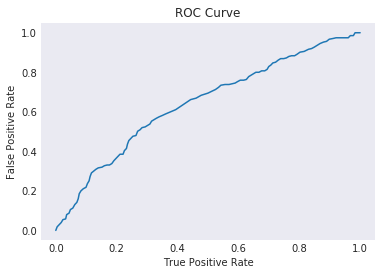

Training set ROC: 0.6418060064935066


In [50]:
roc = trainingSummary_small.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: ' + str(trainingSummary_small.areaUnderROC))

In [133]:
objectiveHistory = trainingSummary_small.objectiveHistory

In [134]:
objectiveHistory

[0.5450611331247501,
 0.537565676579473,
 0.5304127789669243,
 0.5282731281354065,
 0.5281851892167337,
 0.5281285054262518,
 0.5281036067941927,
 0.5280990332504583,
 0.5280982040098371,
 0.528098125623702,
 0.5280981244932045]

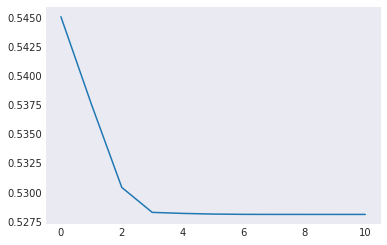

In [136]:
plt.plot(objectiveHistory)

In [51]:
# Read in small test set
small_sample_test = spark.read.parquet('data/smallTestSample.parquet')

In [52]:
small_sample_test.head()

Row(label=0.0, n0=0.0, n1=0.0, n2=0.006, c8='6944', c19='3834', c8_idx=0.0, c19_idx=1.0, c8_OHE=SparseVector(2, {0: 1.0}), c19_OHE=SparseVector(4, {1: 1.0}), features=SparseVector(9, {2: 0.006, 3: 1.0, 6: 1.0}))

In [53]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions_lr_small = lr_small_model.transform(small_sample_test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(predictions_lr_small, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.6077074937608637


In [142]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

lr_eval2 = MulticlassClassificationEvaluator()
print("test set Accuracy:", str(lr_eval2.evaluate(predictions_lr_small, {lr_eval2.metricName: "accuracy"}))  )

test set Accuracy: 0.742498794018331


In [143]:
lr_eval2.params

[Param(parent='MulticlassClassificationEvaluator_4ff9a10c9236f9d8e0b1', name='labelCol', doc='label column name.'),
 Param(parent='MulticlassClassificationEvaluator_4ff9a10c9236f9d8e0b1', name='metricName', doc='metric name in evaluation (f1|weightedPrecision|weightedRecall|accuracy)'),
 Param(parent='MulticlassClassificationEvaluator_4ff9a10c9236f9d8e0b1', name='predictionCol', doc='prediction column name.')]

In [148]:
print("test set Precision??:", str(lr_eval2.evaluate(predictions_lr_small, {lr_eval2.metricName: "weightedPrecision"}))  )
print("test set Recall??:", str(lr_eval2.evaluate(predictions_lr_small, {lr_eval2.metricName: "weightedRecall"}))  )
print("test set f1??:", str(lr_eval2.evaluate(predictions_lr_small, {lr_eval2.metricName: "f1"}))  )

test set Precision??: 0.6925564115693119
test set Recall??: 0.742498794018331
test set f1??: 0.6440633582469697


In [97]:
evaluator.params

[Param(parent='BinaryClassificationEvaluator_477a89b94c65ffbe023e', name='labelCol', doc='label column name.'),
 Param(parent='BinaryClassificationEvaluator_477a89b94c65ffbe023e', name='metricName', doc='metric name in evaluation (areaUnderROC|areaUnderPR)'),
 Param(parent='BinaryClassificationEvaluator_477a89b94c65ffbe023e', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.')]

In [61]:
counttotal = predictions_lr_small.count()
print('count total:', counttotal)

count total: 10365


In [238]:
lp = predictions_lr_small.select( "label", "prediction")

In [72]:
correct = lp.filter(lp["label"] == lp["prediction"]).count()
print('correct:', correct)

correct: 7696


In [70]:
print('accuracy:', correct/float(counttotal))

accuracy: 0.742498794018331


In [237]:
def metricsCalc(lp):
    '''
    Calculate binary classification metrics
    '''
    
    trueP = lp.filter(lp["prediction"] == 1.0).filter(lp["label"] == lp["prediction"]).count()
    trueN = lp.filter(lp["prediction"] == 0.0).filter(lp["label"] == lp["prediction"]).count()
    falseP = lp.filter(lp["prediction"] == 1.0).filter(lp["label"] != lp["prediction"]).count()
    falseN = lp.filter(lp["prediction"] == 0.0).filter(lp["label"] != lp["prediction"]).count()

    # Calculate precision, recall, accuracy, and F1
    precision = float(trueP)/(trueP + falseP) # aka specificity
    recall = float(trueP)/(trueP + falseN)  # aka sensitivity
    accuracy = float(trueP + trueN)/(trueP + trueN + falseP + falseN)
    if trueP != 0:
        f1 = 2 * (precision * recall) / (precision + recall)  # if trueP=0, then precision=0 and recall=0, so f1 doesn't work.
    else:
        f1 = 'TP=0 so cannot calc f1'

    # prints
    print('Number of records:', (trueP+falseP+trueN+falseN))
    print(f'trueP\t\t{trueP}')
    print(f'trueN\t\t{trueN}')
    print(f'falseP\t\t{falseP}')
    print(f'falseN\t\t{falseN}')
    print(f'accuracy\t{accuracy}')
    print(f'precision\t{precision}')
    print(f'recall\t\t{recall}')
    print(f'f1\t\t{f1}')

In [239]:
lp_small = predictions_lr_small.select( "label", "prediction")
metricsCalc(lp_small)

Number of records: 10365
trueP		71
trueN		7625
falseP		60
falseN		2609
accuracy	0.742498794018331
precision	0.5419847328244275
recall		0.026492537313432835
f1		0.050515830665243684


In [110]:
trainingSummary_small.labelCol

'label'

In [111]:
trainingSummary_small.probabilityCol

'probability'

In [127]:
l_all = predictions_lr_small.select( "label", "probability", "prediction")

In [128]:
l_all.show()

+-----+--------------------+----------+
|label|         probability|prediction|
+-----+--------------------+----------+
|  0.0|[0.72835492125822...|       0.0|
|  0.0|[0.85613433044258...|       0.0|
|  0.0|[0.85613433044258...|       0.0|
|  0.0|[0.85613433044258...|       0.0|
|  0.0|[0.85613433044258...|       0.0|
|  0.0|[0.85613433044258...|       0.0|
|  0.0|[0.83191078863056...|       0.0|
|  0.0|[0.83191078863056...|       0.0|
|  0.0|[0.75988364274687...|       0.0|
|  0.0|[0.75988364274687...|       0.0|
|  0.0|[0.75988364274687...|       0.0|
|  0.0|[0.75988364274687...|       0.0|
|  0.0|[0.75988364274687...|       0.0|
|  0.0|[0.75988364274687...|       0.0|
|  0.0|[0.72466576308662...|       0.0|
|  0.0|[0.72466576308662...|       0.0|
|  0.0|[0.76344505299742...|       0.0|
|  0.0|[0.85638677270010...|       0.0|
|  0.0|[0.85671346801646...|       0.0|
|  0.0|[0.91908787911567...|       0.0|
+-----+--------------------+----------+
only showing top 20 rows



In [129]:
l_all.head()

Row(label=0.0, probability=DenseVector([0.7284, 0.2716]), prediction=0.0)

In [130]:
l_pos = l_all.filter(l_all['prediction']==1.0)

In [131]:
l_pos.show()

+-----+--------------------+----------+
|label|         probability|prediction|
+-----+--------------------+----------+
|  0.0|[0.44621554094092...|       1.0|
|  0.0|[0.24772169653926...|       1.0|
|  0.0|[0.19063332156566...|       1.0|
|  1.0|[0.45309698836657...|       1.0|
|  1.0|[0.19039937972810...|       1.0|
|  1.0|[0.00194481278906...|       1.0|
|  1.0|[1.14196272400034...|       1.0|
|  0.0|[0.19737483092537...|       1.0|
|  1.0|[0.47917578826940...|       1.0|
|  1.0|[0.49959284605317...|       1.0|
|  1.0|[0.21280156310072...|       1.0|
|  0.0|[0.49792602431280...|       1.0|
|  0.0|[0.42104827076934...|       1.0|
|  0.0|[0.40536553221745...|       1.0|
|  0.0|[0.39138954435492...|       1.0|
|  0.0|[0.27318312628595...|       1.0|
|  0.0|[0.19603620545852...|       1.0|
|  1.0|[0.46583281417288...|       1.0|
|  1.0|[0.41195922161647...|       1.0|
|  0.0|[0.47897508566274...|       1.0|
+-----+--------------------+----------+
only showing top 20 rows



In [132]:
l_pos.head()

Row(label=0.0, probability=DenseVector([0.4462, 0.5538]), prediction=1.0)

In [90]:
# Log loss

def logloss(true_label, predicted_prob):
  
    epsilon = 10^(-15)
    predicted_prob = max(min(predicted_prob, 1-epsilon), epsilon)
    
    if true_label == 1:
        return -log(predicted_prob)
    else:
        return -log(1 - predicted_prob)

In [109]:
trainingSummary_small
#print(trainingSummary_small)

In [101]:
# feature importance

# https://spark.apache.org/docs/2.2.0/ml-classification-regression.html

print('intercept:', lr_small_model.intercept)
print('coefficients:', lr_small_model.coefficients)


intercept: -1.2282349801739665
coefficients: [2.8687282487666583,0.6751681978279879,-3.0766032897750923,0.050258493422503256,-0.5812470924213744,0.025827077895429925,0.21014400455738527,0.006208130249914411,-0.5960309219171409]


In [157]:
small_sample_train.columns

['label',
 'n0',
 'n1',
 'n2',
 'c8',
 'c19',
 'c8_idx',
 'c19_idx',
 'c8_OHE',
 'c19_OHE',
 'features']

#### regularization and cross validation

In [153]:
# Logisitic Regression with Regularization and Cross Validation for Hyperparameter Tuning

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 

lr_small_reg = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)

paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr_small_reg.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr_small_reg.elasticNetParam, [0.5, 0.7, 0.9]) \
    .build()

crossval_lr_small = CrossValidator(estimator=lr_small_reg,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=BinaryClassificationEvaluator(),
                             numFolds=5)

#fit model to training data
lr_small_reg_model = crossval_lr_small.fit(small_sample_train)

#Transform test data
lr_small_reg_result = lr_small_reg_model.transform(small_sample_test)

#view id, label, prediction and probability from result of modeling
lr_small_reg_result.select('label', 'prediction', 'probability').show(10)


+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.75004694775605...|
|  0.0|       0.0|[0.82726170576101...|
|  0.0|       0.0|[0.82726170576101...|
|  0.0|       0.0|[0.82726170576101...|
|  0.0|       0.0|[0.82726170576101...|
|  0.0|       0.0|[0.82726170576101...|
|  0.0|       0.0|[0.81700622602457...|
|  0.0|       0.0|[0.81700622602457...|
|  0.0|       0.0|[0.76224960882026...|
|  0.0|       0.0|[0.76224960882026...|
+-----+----------+--------------------+
only showing top 10 rows



In [167]:
print('Best Hyperparameters for Small Sample dataset')
print("best regParam:", lr_small_reg_model.bestModel.regParam)
print("best elasticNetParam:", lr_small_reg_model.bestModel.elasticNetParam)

Best Hyperparameters for Small Sample dataset
best regParam: LogisticRegression_4542b0fd3fd28f383cc3__regParam
best elasticNetParam: LogisticRegression_4542b0fd3fd28f383cc3__elasticNetParam


In [236]:
#lr_small_reg_model.getEstimatorParamMaps()

In [175]:
lr_small_reg_model.getEstimatorParamMaps()[ np.argmax(lr_small_reg_model.avgMetrics) ]

{Param(parent='LogisticRegression_4542b0fd3fd28f383cc3', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
 Param(parent='LogisticRegression_4542b0fd3fd28f383cc3', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.9}

#### Best hyperparameters for small sample: regParam = 0.01; elasticNetParam = 0.9.

In [217]:
print('intercept:', lr_small_reg_model.bestModel.intercept)
print('coefficients:', lr_small_reg_model.bestModel.coefficients)

intercept: -1.2090852455788703
coefficients: [2.478052796049695,0.06401468125312675,-0.6580943688652904,0.04402230673054404,-0.3572683651957661,0.0,0.07014881268525996,0.0,-0.48191783947288547]


In [156]:
lp_reg = lr_small_reg_result.select( "label", "prediction")
metricsCalc(lp_reg)

Number of records: 10365
trueP		56
trueN		7641
falseP		44
falseN		2624
accuracy	0.7425952725518572
precision	0.56
recall		0.020895522388059702
f1		0.040287769784172665


## Read in (medium) sample and apply Logistic Regression

In [196]:
### NOTE: Per Alex, train and test are reversed, so read them in reverse order.
sample_train = spark.read.parquet('data/testSample.parquet')
sample_test = spark.read.parquet('data/trainSample.parquet')

In [184]:
sample_train.head()

Row(label=0.0, n0=0.0, n1=0.0, n2=0.00016070711128967456, n3=0.03424657534246575, n4=0.0025729368529526933, n5=0.0, n6=0.0, n7=0.017241379310344827, n8=0.0016054227613271496, n9=0.0, n10=0.0, n11=0.0, n12=0.016778523489932886, c0='5684', c1='8609', c2='9077', c3='6365', c4='4903', c5='2646', c6='2630', c7='84', c8='6944', c9='8539', c10='5511', c11='1635', c12='6300', c13='2527', c14='5306', c15='7065', c16='4857', c17='2077', c18='None', c19='None', c20='2164', c21='None', c22='4324', c23='1592', c24='None', c25='None', c0_idx=0.0, c1_idx=222.0, c2_idx=2612.0, c3_idx=6.0, c4_idx=1.0, c5_idx=1.0, c6_idx=1128.0, c7_idx=0.0, c8_idx=0.0, c9_idx=0.0, c10_idx=1061.0, c11_idx=1297.0, c12_idx=1076.0, c13_idx=1.0, c14_idx=1333.0, c15_idx=556.0, c16_idx=4.0, c17_idx=844.0, c18_idx=0.0, c19_idx=0.0, c20_idx=260.0, c21_idx=0.0, c22_idx=4.0, c23_idx=2.0, c24_idx=0.0, c25_idx=0.0, c19_OHE=SparseVector(4, {0: 1.0}), c6_OHE=SparseVector(1950, {1128: 1.0}), c16_OHE=SparseVector(10, {4: 1.0}), c10_OHE=

In [186]:
sample_test.head()

Row(label=0.0, n0=0.0, n1=0.0001520912547528517, n2=0.0, n3=0.0, n4=0.0, n5=0.0, n6=0.0, n7=0.0, n8=0.0, n9=0.0, n10=0.0, n11=0.0, n12=0.0, c0='5684', c1='8017', c2='1044', c3='5785', c4='9704', c5='8079', c6='288', c7='84', c8='6944', c9='8539', c10='7424', c11='677', c12='9161', c13='2527', c14='8664', c15='7351', c16='2577', c17='7987', c18='None', c19='None', c20='8589', c21='None', c22='4324', c23='5834', c24='None', c25='None', c0_idx=0.0, c1_idx=0.0, c2_idx=533.0, c3_idx=131.0, c4_idx=0.0, c5_idx=0.0, c6_idx=431.0, c7_idx=0.0, c8_idx=0.0, c9_idx=0.0, c10_idx=203.0, c11_idx=502.0, c12_idx=330.0, c13_idx=1.0, c14_idx=587.0, c15_idx=190.0, c16_idx=8.0, c17_idx=393.0, c18_idx=0.0, c19_idx=0.0, c20_idx=442.0, c21_idx=0.0, c22_idx=4.0, c23_idx=219.0, c24_idx=0.0, c25_idx=0.0, c19_OHE=SparseVector(4, {0: 1.0}), c6_OHE=SparseVector(1950, {431: 1.0}), c16_OHE=SparseVector(10, {8: 1.0}), c10_OHE=SparseVector(1376, {203: 1.0}), c14_OHE=SparseVector(1333, {587: 1.0}), c21_OHE=SparseVector(8

In [188]:
sample_train.columns

['label',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n11',
 'n12',
 'c0',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c6',
 'c7',
 'c8',
 'c9',
 'c10',
 'c11',
 'c12',
 'c13',
 'c14',
 'c15',
 'c16',
 'c17',
 'c18',
 'c19',
 'c20',
 'c21',
 'c22',
 'c23',
 'c24',
 'c25',
 'c0_idx',
 'c1_idx',
 'c2_idx',
 'c3_idx',
 'c4_idx',
 'c5_idx',
 'c6_idx',
 'c7_idx',
 'c8_idx',
 'c9_idx',
 'c10_idx',
 'c11_idx',
 'c12_idx',
 'c13_idx',
 'c14_idx',
 'c15_idx',
 'c16_idx',
 'c17_idx',
 'c18_idx',
 'c19_idx',
 'c20_idx',
 'c21_idx',
 'c22_idx',
 'c23_idx',
 'c24_idx',
 'c25_idx',
 'c19_OHE',
 'c6_OHE',
 'c16_OHE',
 'c10_OHE',
 'c14_OHE',
 'c21_OHE',
 'c20_OHE',
 'c4_OHE',
 'c12_OHE',
 'c25_OHE',
 'c5_OHE',
 'c15_OHE',
 'c24_OHE',
 'c2_OHE',
 'c8_OHE',
 'c22_OHE',
 'c13_OHE',
 'c1_OHE',
 'c11_OHE',
 'c17_OHE',
 'c18_OHE',
 'c0_OHE',
 'c23_OHE',
 'c9_OHE',
 'c7_OHE',
 'c3_OHE',
 'features']

In [190]:
sample_train.distinct().count()

41332

In [191]:
sample_test.distinct().count()

4693

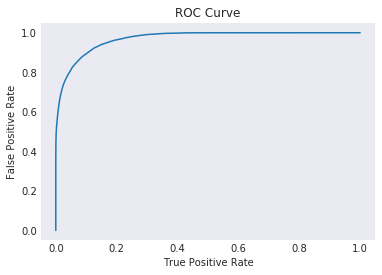

Training set ROC: 0.9693825545925725


In [245]:
lr_sample = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=80, standardization=False)
lr_sample_model = lr_sample.fit(sample_train)
trainingSummary_sample = lr_sample_model.summary

roc = trainingSummary_sample.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: ' + str(trainingSummary_sample.areaUnderROC))

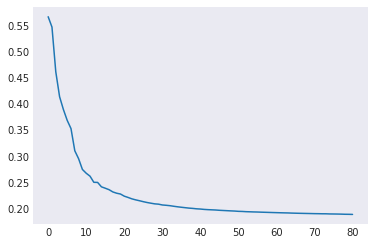

In [246]:
objectiveHistory = trainingSummary_sample.objectiveHistory
plt.plot(objectiveHistory)

In [244]:
objectiveHistory

[0.5670952164187563,
 0.5472669883925428,
 0.4617428672903857,
 0.41391146682897784,
 0.38942525754145335,
 0.36864472392015873,
 0.35279969416858153,
 0.3103149373156345,
 0.2950978727421059,
 0.2745285320079837,
 0.2672807888880707,
 0.2616469059907713,
 0.24993549967773623,
 0.2496756111951745,
 0.24126130637246967,
 0.2385883262374011,
 0.23578360543850788,
 0.23145938690586962,
 0.2290067624430102,
 0.22747080420531432,
 0.22336849193942454,
 0.22091403019932607,
 0.2182262136809893,
 0.21627427465379828,
 0.21460359923523903,
 0.21281114123480405,
 0.21120506092005287,
 0.20988146622360299,
 0.20862727803194728,
 0.20803525570428924,
 0.2064939440644126,
 0.20588673653054712,
 0.2051249814907131,
 0.20400414133451789,
 0.20299987632082273,
 0.20211842362797697,
 0.2012907136569904,
 0.2004796414305319,
 0.19991141134930043,
 0.1991333713955443,
 0.19868775203718278]

In [247]:
lr_sample_model.summary.accuracy  # training set only

0.9161182618794155

In [251]:
#test_acc = lr_sample_model.evaluate(sample_test)
#test_acc.summary.accuracy

In [252]:
predictions_lr_sample = lr_sample_model.transform(sample_test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(predictions_lr_small, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.6077074937608642


In [253]:
lp_sample = predictions_lr_sample.select( "label", "prediction")
metricsCalc(lp_sample)

Number of records: 4693
trueP		380
trueN		2747
falseP		767
falseN		799
accuracy	0.6663115278073727
precision	0.33129904097646035
recall		0.32230703986429177
f1		0.32674118658641443


In [268]:
# Logisitic Regression with Regularization and Cross Validation for Hyperparameter Tuning

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 

#lr_sample_reg = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=80, standardization=False)
lr_sample_reg = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=80)

paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr_sample_reg.regParam, [0.001, 0.01, 0.03]) \
    .addGrid(lr_sample_reg.elasticNetParam, [0.3, 0.5, 0.7]) \
    .build()

crossval_lr_sample = CrossValidator(estimator=lr_sample_reg,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=BinaryClassificationEvaluator(),
                             numFolds=5)

#fit model to training data
lr_sample_reg_model = crossval_lr_sample.fit(sample_train)

#Transform test data
lr_sample_reg_result = lr_sample_reg_model.transform(sample_test)

#view id, label, prediction and probability from result of modeling
lr_sample_reg_result.select('label', 'prediction', 'probability').show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.86182412973191...|
|  0.0|       0.0|[0.78449407076323...|
|  0.0|       0.0|[0.67555008560766...|
|  0.0|       0.0|[0.80438435996795...|
|  0.0|       0.0|[0.92632968790738...|
|  0.0|       0.0|[0.90937962858943...|
|  0.0|       0.0|[0.77013535164624...|
|  0.0|       0.0|[0.52975579836242...|
|  0.0|       0.0|[0.70986154871933...|
|  0.0|       0.0|[0.79394201615931...|
+-----+----------+--------------------+
only showing top 10 rows



In [269]:
lr_sample_reg_model.getEstimatorParamMaps()[ np.argmax(lr_sample_reg_model.avgMetrics) ]

{Param(parent='LogisticRegression_4507bad8e0079acae182', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
 Param(parent='LogisticRegression_4507bad8e0079acae182', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5}

In [270]:
print('intercept:', lr_sample_reg_model.bestModel.intercept)
print('coefficients:', lr_sample_reg_model.bestModel.coefficients)

intercept: -1.242008689485966
coefficients: (24135,[1,3,4,5,7,9,10,12,14,15,16,20,24,33,37,43,56,58,74,80,84,87,122,146,147,159,204,208,278,286,294,304,339,363,404,417,433,462,485,512,614,652,720,745,820,996,1008,1139,1180,1181,1203,1410,1487,1517,1593,1720,1779,1850,1928,1967,1969,1971,1972,1974,1975,1978,1990,1991,2009,2010,2026,2029,2033,2036,2049,2054,2069,2076,2091,2124,2149,2164,2214,2247,2296,2325,2359,2377,2398,2489,2494,2503,2513,2554,2601,2646,2654,2806,2856,2872,2911,2960,3094,3151,3179,3220,3241,3336,3355,3360,3367,3377,3379,3380,3381,3382,3424,3431,3449,3461,3465,3492,3494,3510,3530,3550,3633,3663,3685,3719,3740,3754,3783,3797,3818,3819,3847,3858,3862,3876,3902,3935,3944,3958,4024,4027,4030,4249,4251,4363,4448,4467,4473,4523,4686,4687,4702,4704,4705,4706,4708,4757,4800,4809,4888,5120,5124,5157,5170,5258,5316,5385,5410,5566,5719,5721,5777,5939,5949,6001,6201,6301,6421,6496,6526,6624,6653,6660,6710,6797,6828,6854,6855,6967,7006,7045,7080,7213,7217,7220,7222,7225,7227,7229,72

In [271]:
lp_reg_sample = lr_sample_reg_result.select( "label", "prediction")
metricsCalc(lp_reg_sample)

Number of records: 4693
trueP		138
trueN		3412
falseP		102
falseN		1041
accuracy	0.7564457702961858
precision	0.575
recall		0.11704834605597965
f1		0.1945031712473573


## Read full training and test data and apply Logistic Regression

In [196]:
train = spark.read.parquet('data/train.parquet')
test = spark.read.parquet('data/test.parquet')

In [223]:
train.head()

In [224]:
test.head()

In [225]:
train.columns

In [226]:
train.distinct().count()

In [227]:
test.distinct().count()

In [229]:
# Non-CV version

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=40)
lr_model = lr.fit(train)
trainingSummary = lr_model.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: ' + str(trainingSummary.areaUnderROC))

"lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=40)\nlr_model = lr.fit(train)\ntrainingSummary = lr_model.summary\n\nroc = trainingSummary.roc.toPandas()\nplt.plot(roc['FPR'],roc['TPR'])\nplt.ylabel('False Positive Rate')\nplt.xlabel('True Positive Rate')\nplt.title('ROC Curve')\nplt.show()\nprint('Training set ROC: ' + str(trainingSummary.areaUnderROC))\n"

In [230]:
objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)

In [231]:
objectiveHistory

In [ ]:
# Non-CV run

predictions_lr = lr_model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(predictions_lr, {evaluator.metricName: "areaUnderROC"})))

In [ ]:
lp_full = predictions_lr.select( "label", "prediction")
metricsCalc(lp_full)

In [232]:
# Logisitic Regression with Regularization and Cross Validation for Hyperparameter Tuning

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 

lr_reg = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=30)

paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr_reg.regParam, [0.001, 0.01, 0.1]) \
    .addGrid(lr_reg.elasticNetParam, [0.3, 0.5, 0.7]) \
    .build()

crossval_lr = CrossValidator(estimator=lr_reg,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=BinaryClassificationEvaluator(),
                             numFolds=5)

#fit model to training data
lr_reg_model = crossval_lr.fit(train)

#Transform test data
lr_reg_result = lr_reg_model.transform(test)

#view id, label, prediction and probability from result of modeling
lr_reg_result.select('label', 'prediction', 'probability').show(10)


"\nfrom pyspark.ml.tuning import CrossValidator, ParamGridBuilder \n\nlr_reg = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=30)\n\nparamGrid_lr = ParamGridBuilder()     .addGrid(lr_reg.regParam, [0.01, 0.1, 1.0])     .addGrid(lr_reg.elasticNetParam, [0.5, 0.7, 0.9])     .build()\n\ncrossval_lr = CrossValidator(estimator=lr_reg,\n                             estimatorParamMaps=paramGrid_lr,\n                             evaluator=BinaryClassificationEvaluator(),\n                             numFolds=5)\n\n#fit model to training data\nlr_reg_model = crossval_lr.fit(train)\n\n#Transform test data\nlr_reg_result = lr_reg_model.transform(test)\n\n#view id, label, prediction and probability from result of modeling\nlr_reg_result.select('label', 'prediction', 'probability').show(10)\n"

In [233]:
lr_reg_model.getEstimatorParamMaps()[ np.argmax(lr_reg_model.avgMetrics) ]

In [234]:
print('intercept:', lr_reg_model.bestModel.intercept)
print('coefficients:', lr_reg_model.bestModel.coefficients)

In [235]:
lp_reg = lr_reg_result.select( "label", "prediction")
metricsCalc(lp_reg)